In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

'1.12.0'

In [71]:
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit

iris = datasets.load_iris()
type(iris["feature_names"])

list

In [69]:
features = pd.DataFrame(iris["data"])
target = pd.Series(iris["target"])
flower_names = iris["target_names"]
feature_names = iris["feature_names"]

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, target):
    X_train = features.loc[train_index]
    y_train = target.loc[train_index]
    X_test = features.loc[test_index]
    y_test = target.loc[test_index]

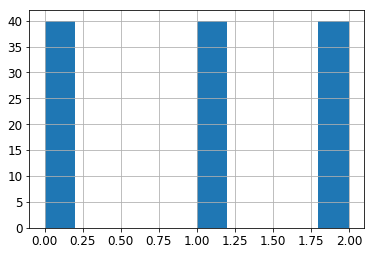

In [4]:
y_train.hist() # Just to confirm the stratification

We will use One-Hot encoding for our labels as it makes it more reasonable to pass into a neural network model

In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
y_test_1hot = enc.fit_transform([[label] for label in y_test])

y_train_1hot[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## Constructing the model

We'll try building a Keras neural network for this data set

In [18]:
import keras

keras.backend.clear_session()

nn = keras.models.Sequential()

Dense = keras.layers.Dense

nn.add(Dense(units = 16, activation="relu", input_dim=4))
# nn.add(tf.keras.layers.Dropout(0.1))
nn.add(Dense(units = 16, activation="relu"))
# nn.add(tf.keras.layers.Dropout(0.2))
# nn.add(Dense(units = 16, activation="relu"))
nn.add(Dense(units=3, activation='softmax'))
# nn.add(Dense(units=3))

nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


## Training

In [19]:
nn.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [20]:
tb_callback = keras.callbacks.TensorBoard(log_dir=root_logdir, histogram_freq=0, batch_size=32,
                                             write_graph=True, write_grads=False, write_images=False,
                                             embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
                                             embeddings_data=None)

history = nn.fit(X_train.values, y_train_1hot, epochs=100, batch_size = 20, callbacks=[tb_callback])

Epoch 1/100
120/120 [==============================] - 0s 673us/step - loss: 1.2157 - acc: 0.3917
Epoch 2/100
120/120 [==============================] - 0s 57us/step - loss: 1.0034 - acc: 0.6667
Epoch 3/100
120/120 [==============================] - 0s 49us/step - loss: 0.9222 - acc: 0.6667
Epoch 4/100
120/120 [==============================] - 0s 47us/step - loss: 0.8696 - acc: 0.6667
Epoch 5/100
120/120 [==============================] - 0s 56us/step - loss: 0.8297 - acc: 0.6667
Epoch 6/100
120/120 [==============================] - 0s 52us/step - loss: 0.7986 - acc: 0.6667
Epoch 7/100
120/120 [==============================] - 0s 57us/step - loss: 0.7701 - acc: 0.6667
Epoch 8/100
120/120 [==============================] - 0s 57us/step - loss: 0.7421 - acc: 0.6667
Epoch 9/100
120/120 [==============================] - 0s 56us/step - loss: 0.7210 - acc: 0.6750
Epoch 10/100
120/120 [==============================] - 0s 61us/step - loss: 0.6984 - acc: 0.6750
Epoch 11/100
120/120 [======

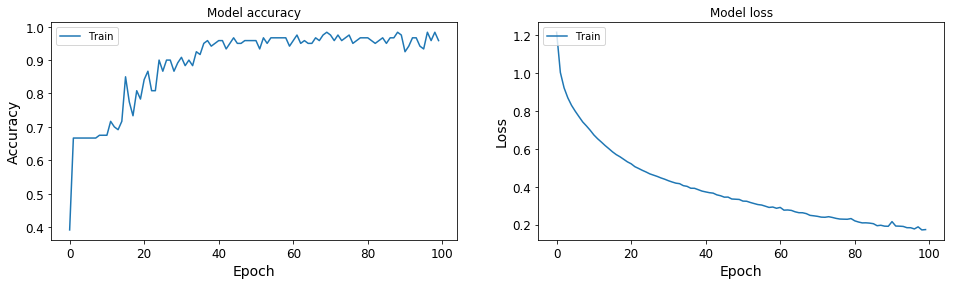

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))

# Plot training & validation accuracy values
axs[0].plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
loss_and_metrics = nn.evaluate(X_test, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

30/30 [==============================] - 0s 1ms/step
Scores on test set: loss=0.172 accuracy=1.0000


## LRP

Now we try using LRP to generate relevances

In [82]:

import innvestigate
import innvestigate.utils as iutils


def perform_analysis(model, analyzer, data, labels):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    header = "{:^30} {} {}".format("Relevances","Pred", "Actual")
    print(header)
    
    for rel,pred,actual in zip(analysis,prediction, labels):
        result = "{} {:d} {:d}".format(np.around(rel,4), np.argmax(pred), actual)
        print(result)
    df_anal = pd.DataFrame(analysis)
    print()
#     print(df_anal.describe())
    return df_anal

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(nn)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)
lrp = innvestigate.create_analyzer("lrp.z", model_wo_sm)

flowers=X_test.values
types=y_test.values

# perform_analysis(nn,gradient_analyzer,flowers,types)
lrp_results = perform_analysis(nn,lrp,flowers,types)

          Relevances           Pred Actual
[ 3.8693  3.229  -2.1708 -0.269 ] 0 0
[-8.7421 -3.0391 10.8952  2.8337] 2 2
[ 0.1307  1.2498 -0.1859 -0.4105] 1 1
[ 0.2565  1.1604 -0.2504 -0.4303] 1 1
[ 3.8693  3.4442 -2.1708 -0.269 ] 0 0
[ 0.8061  2.1398 -1.1574 -1.0068] 1 1
[ 3.665   3.4208 -1.0785 -0.2242] 0 0
[ 4.7487  3.6595 -2.8388 -0.269 ] 0 0
[-9.3154 -3.0391 11.5622  3.1485] 2 2
[ 0.691   1.9453 -1.1082 -0.9438] 1 1
[-10.4619  -2.9378  14.0081   2.8337] 2 2
[-9.8886 -3.1404 11.3399  3.6208] 2 2
[-9.3154 -3.0391 12.8963  3.4634] 2 2
[ 0.8189  2.075  -1.1082 -0.9438] 1 1
[ 4.3969  3.6595 -2.5048 -0.269 ] 0 0
[ 4.3969  3.5518 -2.3378 -0.269 ] 0 0
[ 4.6211  3.8009 -1.2942 -0.2242] 0 0
[ 0.7166  1.6211 -0.9604 -0.6921] 1 1
[ 0.7806  1.8805 -1.1574 -0.8809] 1 1
[-8.5988 -3.0391 10.6728  2.8337] 2 2
[ 4.3024  3.5158 -1.6177 -0.2242] 0 0
[-9.602  -3.1404 12.4516  3.7782] 2 2
[ 0.8445  1.8805 -1.1328 -0.818 ] 1 1
[-8.7421 -2.6339 12.4516  2.204 ] 2 2
[-9.172  -2.8365 12.4516  3.4634] 2 2
[ 0

          Relevances           Pred Actual
[ 3.8693  3.229  -2.1708 -0.269 ] 0 0
[ 3.8693  3.4442 -2.1708 -0.269 ] 0 0
[ 3.665   3.4208 -1.0785 -0.2242] 0 0
[ 4.7487  3.6595 -2.8388 -0.269 ] 0 0
[ 4.3969  3.6595 -2.5048 -0.269 ] 0 0
[ 4.3969  3.5518 -2.3378 -0.269 ] 0 0
[ 4.6211  3.8009 -1.2942 -0.2242] 0 0
[ 4.3024  3.5158 -1.6177 -0.2242] 0 0
[ 5.0125  4.09   -2.8388 -0.4034] 0 0
[ 4.1431  3.2308 -1.5099 -0.2242] 0 0

          Relevances           Pred Actual
[ 0.1307  1.2498 -0.1859 -0.4105] 1 1
[ 0.2565  1.1604 -0.2504 -0.4303] 1 1
[ 0.8061  2.1398 -1.1574 -1.0068] 1 1
[ 0.691   1.9453 -1.1082 -0.9438] 1 1
[ 0.8189  2.075  -1.1082 -0.9438] 1 1
[ 0.7166  1.6211 -0.9604 -0.6921] 1 1
[ 0.7806  1.8805 -1.1574 -0.8809] 1 1
[ 0.8445  1.8805 -1.1328 -0.818 ] 1 1
[ 0.8573  1.9453 -1.2313 -1.0697] 1 1
[ 0.8445  1.9453 -1.0836 -0.8809] 1 1

          Relevances           Pred Actual
[-8.7421 -3.0391 10.8952  2.8337] 2 2
[-9.3154 -3.0391 11.5622  3.1485] 2 2
[-10.4619  -2.9378  14.0081   2.8

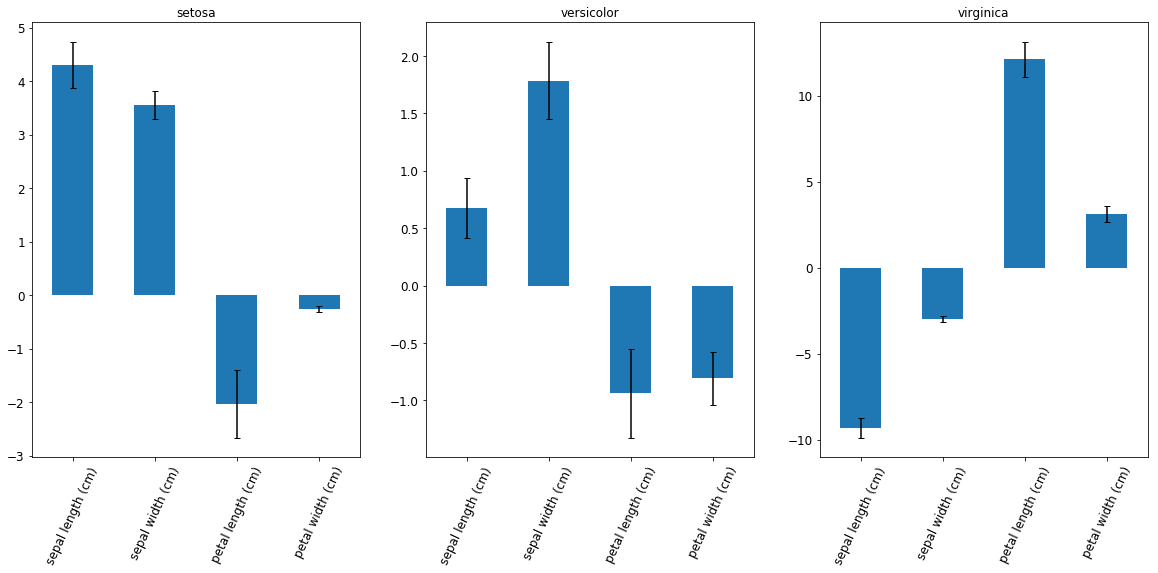

In [78]:
# # Applying the analyzer for all flowers

fig, axs = plt.subplots(1, 3, figsize=(20,8))

for label in range(0,3):
#     label =  # Just looking at first flower type
    label_idxs = (y_test == label)

    flowers = X_test[label_idxs].values
    types = y_test[label_idxs].values
    lrp_results = perform_analysis(nn,lrp,flowers,types)
    
    avgs = lrp_results.mean()
    errs = lrp_results.std()
    
    ax=avgs.plot(kind="bar",ax=axs[label],yerr=errs, capsize=3, title=flower_names[label])
    ax.set_xticklabels(feature_names, rotation=65)

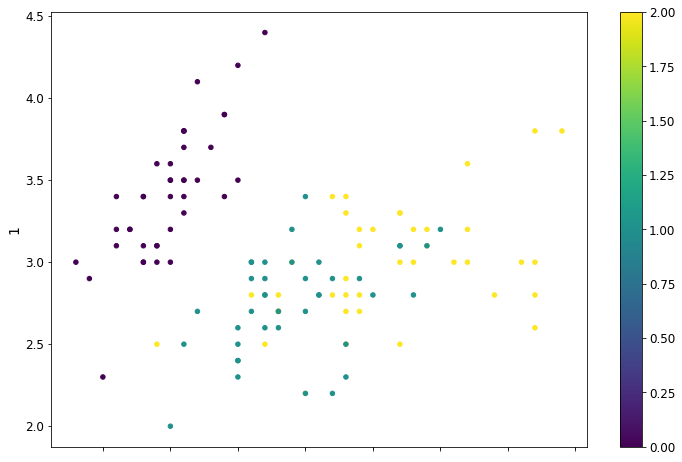

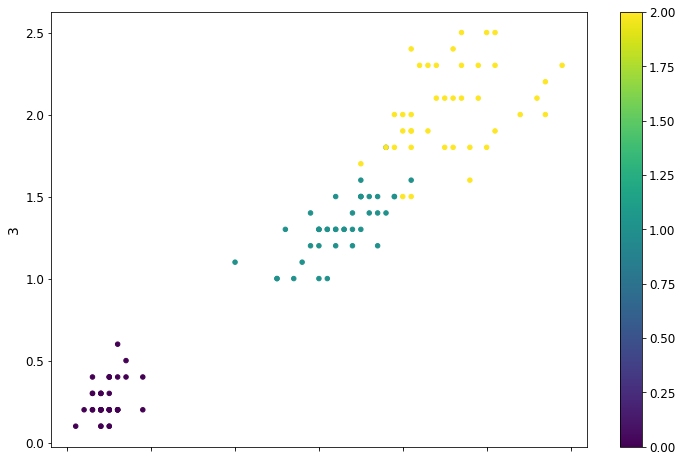

In [90]:
# predictions = nn.predict(X_train)
X_train.plot.scatter(figsize=[12,8],x=0,y=1,c=y_train, colormap="viridis")
plt.show()
X_train.plot.scatter(figsize=[12,8],x=2,y=3,c=y_train, colormap="viridis")